In [ ]:
pip install opendatasets --upgrade -q

In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection")

Skipping, found downloaded files in "./news-headlines-dataset-for-sarcasm-detection" (use force=True to force download)


In [ ]:
import torch
import torch.nn as nn
from torch.optim import Adam
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'current device is {device}')

current device is cuda


In [ ]:
df = pd.read_json('/content/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json', lines=True)

In [ ]:
df.isna().sum()

,0
article_link,0
headline,0
is_sarcastic,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26709 entries, 0 to 26708
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article_link  26709 non-null  object
 1   headline      26709 non-null  object
 2   is_sarcastic  26709 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 626.1+ KB


In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26708 entries, 0 to 26708
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article_link  26708 non-null  object
 1   headline      26708 non-null  object
 2   is_sarcastic  26708 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 834.6+ KB


In [ ]:
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [ ]:
df.drop(['article_link'], inplace=True, axis=1)

In [ ]:
df.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


**Bir adet tekrarlanan  veri silindi**


In [ ]:
features = np.array(df['headline'])
labels = np.array(df['is_sarcastic'])

In [ ]:
X_train, X_test,y_train,  y_test = train_test_split(features, labels, test_size=.3)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=.5)

In [ ]:
X_train.shape, X_val.shape, X_test.shape

((18695,), (4006,), (4007,))

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('google-bert/bert-base-uncased')
bert_base = AutoModel.from_pretrained('google-bert/bert-base-uncased')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
class dataset(Dataset):

  def __init__(self, X,Y):
    self.X = [ tokenizer(
        x,
        max_length = 100,
        truncation = True,
        padding = "max_length",
        return_tensors = 'pt'). to(device)
        for x in X
               ]
    self.Y = torch.tensor(Y, dtype=torch.float32).to(device)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.X[idx], self.Y[idx]

train_dataset = dataset(X_train, y_train)
validation_dataset = dataset(X_val, y_val)
test_dataset = dataset(X_test, y_test)

In [ ]:
batch_size = 2048
epochs = 100
lr = 1e-4

In [ ]:
generator = torch.Generator().manual_seed(12)

In [ ]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, drop_last=True,
                          shuffle=True, generator=generator)
val_loader = DataLoader(dataset=validation_dataset, batch_size=batch_size, drop_last=True,
                          shuffle=True, generator=generator)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, drop_last=True,
                          shuffle=True, generator=generator)

In [ ]:
class bert_model(nn.Module):

  def __init__(self, bert):
    super().__init__()
    self.bert = bert
    self.ln1 = nn.Linear(768, 768 // 2)
    self.ln2 = nn.Linear(768 // 2, 1) # here 1 for classificatio task
    self.gelu = torch.nn.GELU(approximate='tanh')
    self.sigmoid = nn.Sigmoid()
    self.dropout = nn.Dropout(0.1, inplace=False)

  def forward(self, input_ids, attention_mask):
    pooled_output = self.bert(input_ids, attention_mask, return_dict = False)[0][:,0]
    output = self.ln1(pooled_output)
    output = self.dropout(output)
    output = self.gelu(output)
    output = self.ln2(output)
    output = self.sigmoid(output)

    return output

In [ ]:
for param in bert_base.parameters():
  param.requires_grad = False

In [ ]:
bert_for_calssification = bert_model(bert_base).to(device)

In [ ]:
bert_for_calssification

bert_model(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

In [ ]:
criterion = nn.BCELoss()
optimizer = Adam(bert_for_calssification.parameters(), lr = lr)

In [ ]:
total_loss_train_plot = []
total_loss_val_plot = []
total_acc_train_plot = []
total_acc_val_plot = []

for epoch in range(epochs):
  total_acc_train = 0
  total_loss_train = 0
  total_acc_val = 0
  total_loss_val = 0

  for index, data in enumerate(train_loader):
    inputs, labels = data
    inputs.to(device)
    labels.to(device)

    prediction = bert_for_calssification(inputs['input_ids'].squeeze(1),inputs['attention_mask'].squeeze(1)).squeeze(1)
    batch_loss = criterion(prediction, labels)
    total_loss_train += batch_loss.item()

    acc = (prediction.round() == labels).sum().item()

    total_acc_train += acc
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  with torch.no_grad():
    for index, data in enumerate(val_loader):
      inputs, labels = data
      inputs.to(device)
      labels.to(device)

      prediction = bert_for_calssification(inputs['input_ids'].squeeze(1), inputs['attention_mask'].squeeze(1)).squeeze(1)
      batch_loss = criterion(prediction, labels)
      total_loss_val += batch_loss.item()

      acc = (prediction.round() == labels).sum().item()

      total_acc_val += acc

  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_loss_val_plot.append(round(total_loss_val/1000, 4))
  total_acc_train_plot.append(round((total_acc_train/train_dataset.__len__()) * 100 , 4))
  total_acc_val_plot.append(round((total_acc_train/validation_dataset.__len__()) * 100 , 4))

  print(f'''Epoch no. {epoch + 1} Train Loss: {total_loss_train/1000:.4f} Train Accuracy: {(total_acc_train/(train_dataset.__len__())*100):.4f} Validation Loss: {total_loss_val/100:.4f} Validation Accuracy: {(total_acc_val/(validation_dataset.__len__())*100):.4f}''')
  print("="*50)

Epoch no. 1 Train Loss: 0.0061 Train Accuracy: 53.8540 Validation Loss: 0.0065 Validation Accuracy: 30.3045
Epoch no. 2 Train Loss: 0.0057 Train Accuracy: 62.3322 Validation Loss: 0.0061 Validation Accuracy: 35.9710
Epoch no. 3 Train Loss: 0.0054 Train Accuracy: 70.6767 Validation Loss: 0.0057 Validation Accuracy: 37.9181
Epoch no. 4 Train Loss: 0.0051 Train Accuracy: 72.4525 Validation Loss: 0.0053 Validation Accuracy: 39.0914
Epoch no. 5 Train Loss: 0.0048 Train Accuracy: 74.6349 Validation Loss: 0.0051 Validation Accuracy: 40.1897
Epoch no. 6 Train Loss: 0.0045 Train Accuracy: 76.3306 Validation Loss: 0.0049 Validation Accuracy: 40.2396
Epoch no. 7 Train Loss: 0.0043 Train Accuracy: 77.7213 Validation Loss: 0.0047 Validation Accuracy: 40.7139
Epoch no. 8 Train Loss: 0.0042 Train Accuracy: 78.8981 Validation Loss: 0.0045 Validation Accuracy: 41.6625
Epoch no. 9 Train Loss: 0.0040 Train Accuracy: 79.7112 Validation Loss: 0.0043 Validation Accuracy: 41.8622
Epoch no. 10 Train Loss: 0.0

KeyboardInterrupt: 

In [ ]:

with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for indx, data in enumerate(test_loader):
    input, label = data
    input.to(device)
    label.to(device)

    prediction = bert_for_calssification(input['input_ids'].squeeze(1), input['attention_mask'].squeeze(1)).squeeze(1)

    batch_loss_val = criterion(prediction, label)
    total_loss_test += batch_loss_val.item()
    acc = ((prediction).round() == label).sum().item()
    total_acc_test += acc

print(f"Accuracy Score is: {round((total_acc_test/X_test.shape[0])*100, 2)}%")

Accuracy Score is: 44.2%


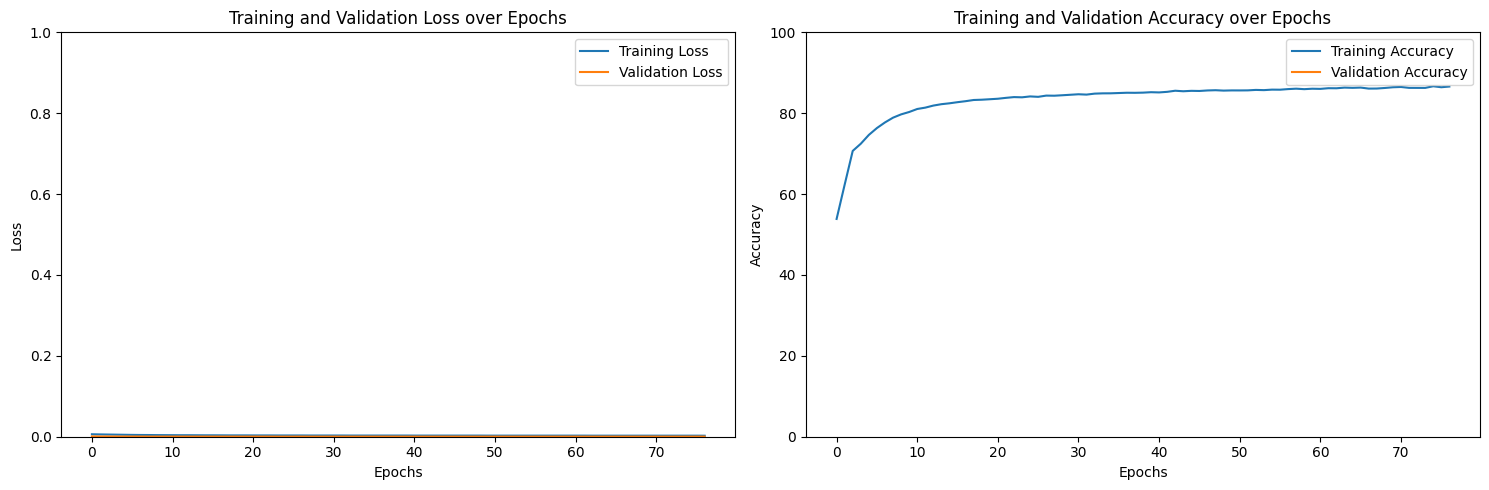

In [ ]:

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_val_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_ylim([0, 1])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_val_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0, 100])
axs[1].legend()

plt.tight_layout()

plt.show()